# Hybrid Classic-Quantum Systems - Third Assignment

You should fill in this Jupyter notebook in order to complete the assignment. Here a small recap of the rules:

- You should **NOT** modify the functions that are already provided in the notebook, unless it is strictly necessary;
- If you want to modify the given functions, please, provide an explanation of why you had to;
- You can define new functions, as soon as they are well commented;
- You can import all libraries you want, as soon as you justify their utilization;
- You can add new cells, as soon as you do not remove the cells where you are supposed to comment your solution;
- This is a group assignment. The maximum number of people is 3;
- Your solution should be commented and accompanied by a small description - you can add additional cells if needed;
- For any issue and doubt, please do not hesitate to use the forum or to write me an email.


# Preliminaries

## Bin Packing Problem (BPP)

The bin packing problem (BPP) is an optimization problem. The final goal is to fit items of different sizes into a finite number of bins, each of a fixed given capacity, minimizing the number of bins used. The problem has many applications, ranging from logistics, multi-processor scheduling.

Computationally, the problem is NP-hard, and the corresponding decision problem, deciding if items can fit into a specified number of bins, is NP-complete.
![np-complete](https://imgs.xkcd.com/comics/np_complete.png)


## Mathematical formulation

The objective function of BPP is to minimize the number of bins used, more formally,
\begin{align} \label{eqn:bpp}
& {\min}
& & \sum*{j=1}^{K} B_j \\
& {\text{subject to}}
& & g(x*{ij}) = \sum*{j=1}^{K} x*{ij} = 1 \qquad \forall i \\
& & & h(x*{ij}) = \sum*{i=1}^N w*{i}x*{ij} \le C\*B_j \qquad \forall j
\end{align}


The constraint $g(x)$ implies that each task can be packed into at most one CPU, and constraint $h(x_{ij})$ says that the requirements of each task can not exceed the given $C$ capacity. In this paper, BPP can be considered as a mixture of inequality and equality-constrained optimization problems.


# Loading BPP instances

First of all, we focus on generating instances of BPP to be used for the evaluation. Each instance is structured in the following way:

$[[w_0, w_1, ..., w_n], C, B, items]$, such that:

- $w_i$ is the weight of item $i$;
- $C$ is the capacity of each bin;
- $B$ is the number of bins;
- $items$ is the number of items

We pre-generated the instances for you and saved them in an attached binary file. You can read them in your code by using the following code:


In [1]:
import pickle


def read_list(filename):
    # for reading also binary mode is important
    with open(filename, "rb") as fp:
        n_list = pickle.load(fp)
        return n_list

In [2]:
# plotting the results
# adapted from https://qiskit.org/ecosystem/optimization/_modules/qiskit_optimization/applications/bin_packing.html

import numpy as np


def interpret(result, n, m):
    x = result.x
    num_items = m
    num_bins = n
    bins = x[:num_bins]
    items = np.array(x[num_bins : num_bins + (num_items * num_bins)]).reshape(
        (num_items, num_bins)
    )
    return [
        [i for i in range(num_items) if bins[j] and items[i, j]]
        for j in range(num_bins)
    ]


def plot(result, n, m, wj, Q):
    import matplotlib.pyplot as plt

    colors = plt.colormaps["jet"].resampled(m)
    items_in_bins = interpret(result, n, m)
    num_bins = len(items_in_bins)
    fig, axes = plt.subplots()
    for _, bin_i in enumerate(items_in_bins):
        sum_items = 0
        for item in bin_i:
            axes.bar(
                _, wj[item], bottom=sum_items, label=f"Item {item}", color=colors(item)
            )
            sum_items += wj[item]
    axes.hlines(
        Q, -0.5, num_bins - 0.5, linestyle="--", color="tab:red", label="Max Weight"
    )
    axes.set_xticks(np.arange(num_bins))
    axes.set_xlabel("Bin")
    axes.set_ylabel("Weight")
    axes.legend()
    return fig

# Transforming BPP into a QUBO

QUBO is a mathematical model that is used to represent combinatorial optimization problems in which the variables are binary $\{0,1\}$ and the objective function with constraints is quadratic. We employ QUBO for BPP because it provides a framework for representing combinatorial optimization problems in a form that can be efficiently solved using quantum computing algorithms designed for QUBO problems, such as VQE or QAOA.

## Slack Variables + Quadratic Penalty Encoding

Qiskit Optimization provides with QuadraticProgram a very generic and powerful representation for optimization problems. However, usually, optimization algorithms cannot handle all possible types of problems that can be modelled, but only a sub-class. Many available quantum optimization algorithms can handle Quadratic Unconstrained Binary Optimization (QUBO) problems. To do so, first, it is necessary to convert a given optimization problem into a QUBO.

Qiskit Optimization provides converters to achieve this conversion whenever possible. More precisely, Qiskit Optimization provides the following converters:

- _InequalityToEquality_: converts inequality constraints into equality constraints with additional slack variables.
- _IntegerToBinary_ : converts integer variables into binary variables and corresponding coefficients.
- _LinearEqualityToPenalty_ : convert equality constraints into additional terms of the object function.
- _QuadraticProgramToQubo_ : a wrapper for IntegerToBinary and LinearEqualityToPenalty for convenience.
  More information available at: https://qiskit.org/documentation/stable/0.19/tutorials/optimization/2_converters_for_quadratic_programs.html

## Penalty-Based Encoding

### Define penalties

To enforce the constraints, we introduce penalty terms to the objective function. These terms penalize solutions that violate the constraints. Firsts, we rewrite constraints $g(x_{ij})$ and $h(x_{ij})$ as follows,
\begin{align*}
g(x*{ij}) = \sum*{j=1}^{K} x*{ij} - 1 = 0 \qquad \forall i \\
h(x*{ij}) = \sum*{i=1}^N w*{i}x\_{ij} - C \cdot B_j \le 0 \qquad \forall j \\
\end{align*}
Second, introduce penalty functions $p_1(\lambda, g(x))$ and $p_2(\beta, h(x))$ with coefficients $\{\lambda, \beta\} \geq 0 $
    \begin{equation}\label{penalty1}
        p_1(\lambda, g(x_{ij})) =
        \begin{cases}
            0 & \text{if $g(x_{ij}) \leq 0$} \\
\lambda g(x*{ij}) & \text{if $g(x*{ij}) > 0$} 
        \end{cases}
    \end{equation}
    \begin{equation}\label{penalty2}
        p_2(\beta, h(x_{ij})) =
        \begin{cases}
            0 & \text{if $h(x_{ij}) \leq 0$} \\
\beta h(x*{ij}) & \text{if $h(x*{ij}) > 0$}
\end{cases}
\end{equation}

In literature, there are multiple methods for penalization such as the exterior penalty function and interior penalty function.

### Injecting Penalties in the Model

To get the final QUBO form we combine penalties with objective function and get

\begin{equation}
\mathcal{F} = \sum*{j=1}^{K} B_j + \sum*{j=1}^{K}p*1(\lambda, g_j) + \sum*{i=1}^{N}p_2(\beta,h_i)
\end{equation}

### Examples of penalty functions

- https://www.stat.cmu.edu/~ryantibs/convexopt-F13/scribes/lec16.pdf
- https://www.rose-hulman.edu/~bryan/lottamath/penalty.pdf


## YOUR TASK

- Apply slack + quadratic penalty
- Apply penalty-based encoding using three functions


# Encoding QUBO into ISING Hamiltonian

The next step is to encode the classical QUBO formulation into a quantum state. There exist techniques to encode classical data into quantum such as basis encoding, amplitude encoding, and angle encoding. In this paper, we apply basis encoding, for which any quantum basis can be chosen, but the common way for doing so is to choose basis $\{-1,1\}$ as follows:
\begin{align}
\label{eqn:to*ising}
\begin{split}
x_i = \frac{1-z_i}{2}\\
z_i\*z_j = \sigma_Z^i \otimes \sigma_Z^j \\
z_i = \sigma_Z^i
\end{split}
\end{align}
where $\sigma_Z^i$ denotes the Pauli-Z matrix
$\begin{pmatrix}
  1 & 0\\ 
  0 & -1
\end{pmatrix}$ on the $i$-th qubit.
The eigenvalues of $\text{I} - \frac{Z}{2}$ are $\{-1,1\}$ with corresponding eigenstates $|0\rangle$ and $|1\rangle$. Thus, we switch from Z to $\text{I} - \frac{Z}{2}$, and rewrite the problem as BPP Ising hamiltonian,
\begin{equation} \label{eqn:final_hamiltonian}
H*{bpp}= \sum*{j=1}^{K} \sigma_j + \sum*{j=1}^{K}p*1(\lambda, g_j) + \sum*{i=1}^{N}p_2(\beta,h_i)
\end{equation}
where $g_j$ and $h_i$ are now functions of $\sigma$.


## YOUR TASK: Encoding the QUBO as an Ising Hamiltonian


# Solving BPP instances

Solve each problem instances using different methods:

## CPLEX optimizer

Classic optimizer, to be used as baseline with all the others.


In [3]:
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import (
    LinearEqualityToPenalty,
    InequalityToEquality,
    IntegerToBinary,
)


def quadratic_penalty(weights, C, B, items):
    # Create a Quadratic Program
    qp = QuadraticProgram()

    # Add binary variables x_{ij} for each item i and bin j
    # x_{ij} = 1 if item i is in bin j, else 0

    for j in range(B):
        qp.binary_var(name=f"B_{j}")

    for i in range(items):
        for j in range(B):
            qp.binary_var(name=f"x_{i}_{j}")

    # Objective function: Minimize the number of bins used
    # This is done by minimizing the sum of B_j, where B_j = 1 if bin j is used
    qp.minimize(linear=[1] * B)

    eq_to_pen = LinearEqualityToPenalty(100)
    # Constraint g(x): Each item i must be in exactly one bin
    for i in range(items):
        qp.linear_constraint(
            linear={f"x_{i}_{j}": 1 for j in range(B)},
            sense="==",
            rhs=1,
            name=f"item_in_one_bin_{i}",
        )
        qp = eq_to_pen.convert(qp)
    neq_to_eq = InequalityToEquality("integer")
    eq_to_pen2 = LinearEqualityToPenalty(200)
    int_to_bin = IntegerToBinary()
    # Constraint h(x): Total weight in each bin j must not exceed its capacity C
    for j in range(B):
        # Create a dictionary for the linear terms
        linear_terms = {f"x_{i}_{j}": weights[i] for i in range(items)}
        # Add the term for B_j with a negative coefficient
        linear_terms[f"B_{j}"] = -C
        qp.linear_constraint(
            linear=linear_terms,
            sense="<=",
            rhs=0,  # Set the RHS to 0
            name=f"bin_capacity_{j}",
        )
        qp = neq_to_eq.convert(qp)
        qp = int_to_bin.convert(qp)
        qp = eq_to_pen2.convert(qp)

    return qp

BPP instance: [[55, 40, 25, 50], 100, 3, 4]
Result: fval=2.0, B_0=0.0, B_1=1.0, B_2=1.0, x_0_0=0.0, x_0_1=1.0, x_0_2=0.0, x_1_0=0.0, x_1_1=1.0, x_1_2=0.0, x_2_0=0.0, x_2_1=0.0, x_2_2=1.0, x_3_0=0.0, x_3_1=0.0, x_3_2=1.0, bin_capacity_0@int_slack@0=0.0, bin_capacity_0@int_slack@1=0.0, bin_capacity_0@int_slack@2=0.0, bin_capacity_0@int_slack@3=0.0, bin_capacity_0@int_slack@4=0.0, bin_capacity_0@int_slack@5=0.0, bin_capacity_0@int_slack@6=0.0, bin_capacity_1@int_slack@0=1.0, bin_capacity_1@int_slack@1=0.0, bin_capacity_1@int_slack@2=1.0, bin_capacity_1@int_slack@3=0.0, bin_capacity_1@int_slack@4=0.0, bin_capacity_1@int_slack@5=0.0, bin_capacity_1@int_slack@6=0.0, bin_capacity_2@int_slack@0=1.0, bin_capacity_2@int_slack@1=0.0, bin_capacity_2@int_slack@2=0.0, bin_capacity_2@int_slack@3=1.0, bin_capacity_2@int_slack@4=1.0, bin_capacity_2@int_slack@5=0.0, bin_capacity_2@int_slack@6=0.0, status=SUCCESS
Number of variables: 36
Interpreted result: [[], [0, 1], [2, 3]]
BPP instance: [[80, 20, 55,

/tmp/ipykernel_499224/149648239.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots()


[[[], [0, 1], [2, 3]],
 [[0], [1, 2, 3], []],
 [[3], [0, 2], [1]],
 [[0, 3], [], [1, 2]],
 [[], [0, 1], [2, 3]],
 [[], [1, 2, 3], [0]],
 [[], [1, 2], [0, 3]],
 [[0, 1], [2]],
 [[0], [1, 2]],
 [[1], [0, 2]],
 [[0], [1, 2]],
 [[0], [1, 2]],
 [[0, 1], [2]],
 [[0, 1], [2]],
 [[0, 1, 2, 3, 4]],
 [[0, 1, 2, 3, 4]],
 [[0, 1, 2, 3, 4]],
 [[0, 1, 2, 3, 4]],
 [[0, 1, 2, 3, 4]],
 [[0, 1, 2, 3, 4]],
 [[0, 1, 2, 3, 4]]]

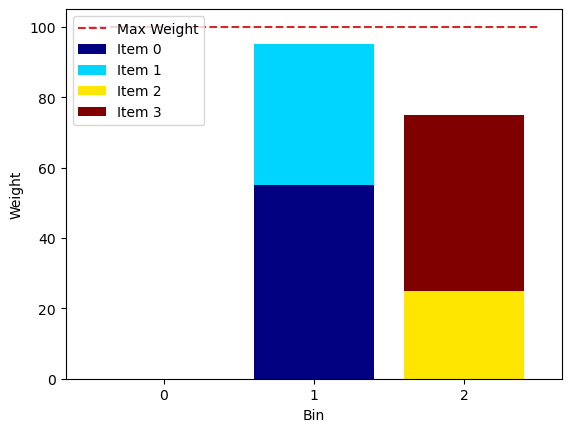

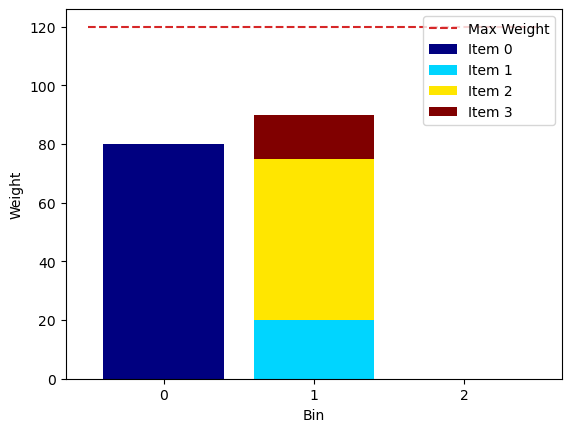

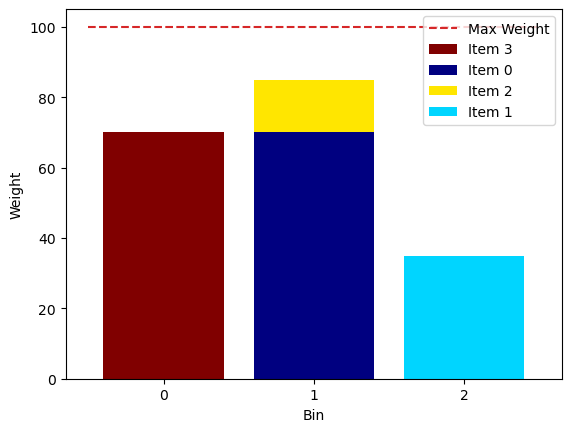

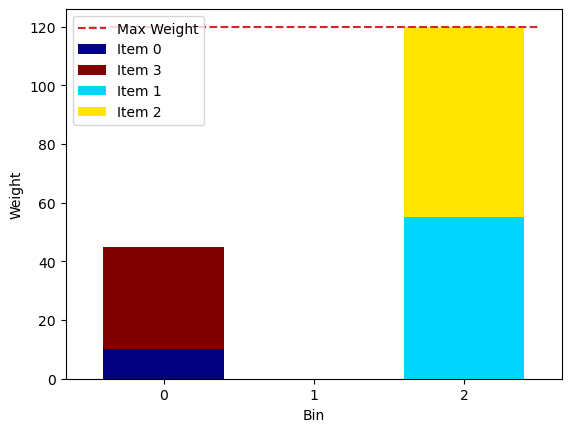

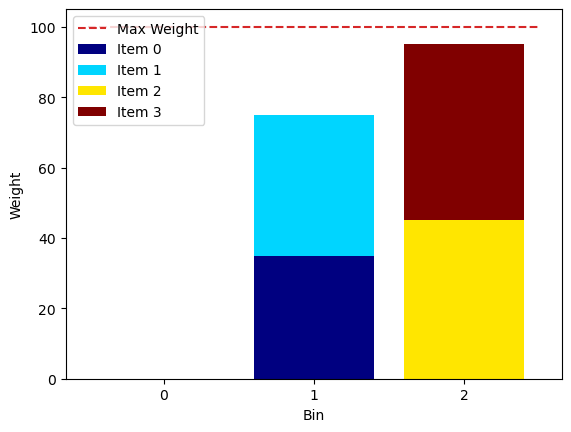

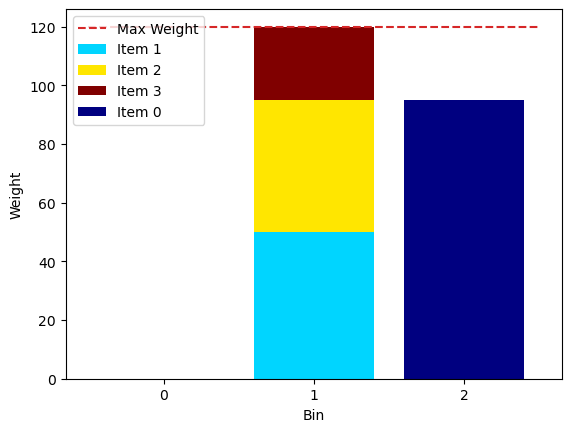

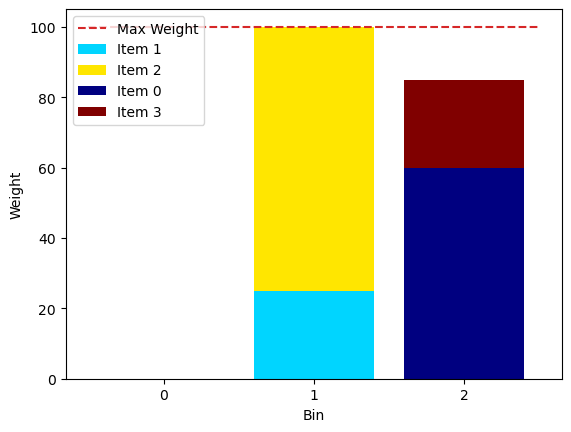

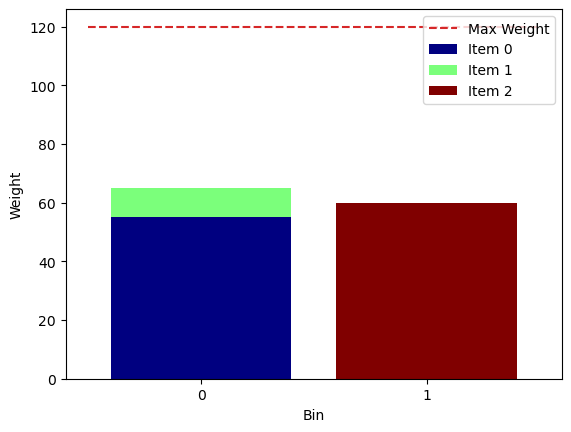

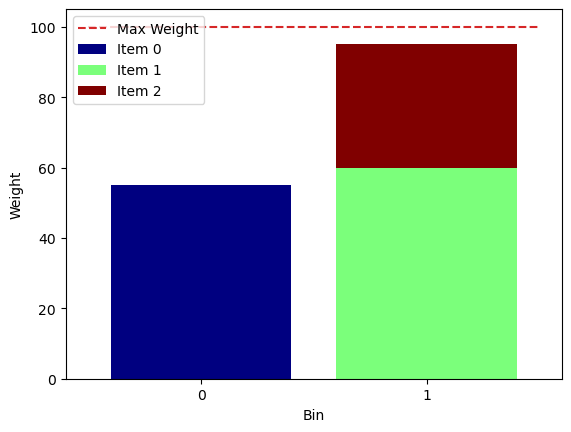

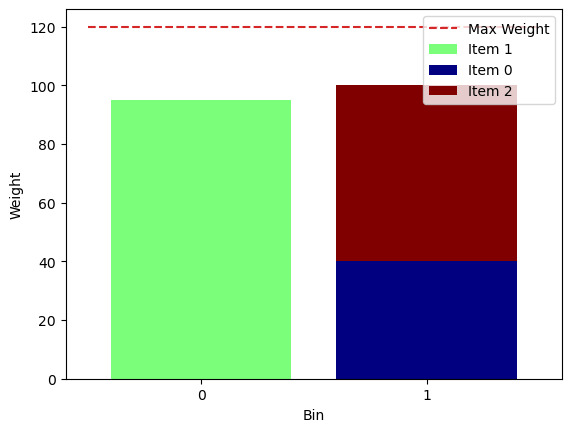

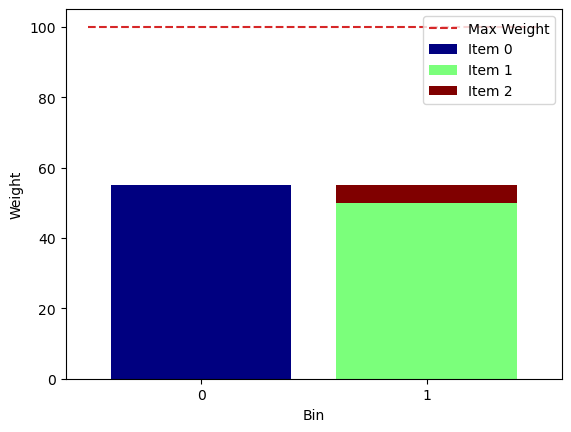

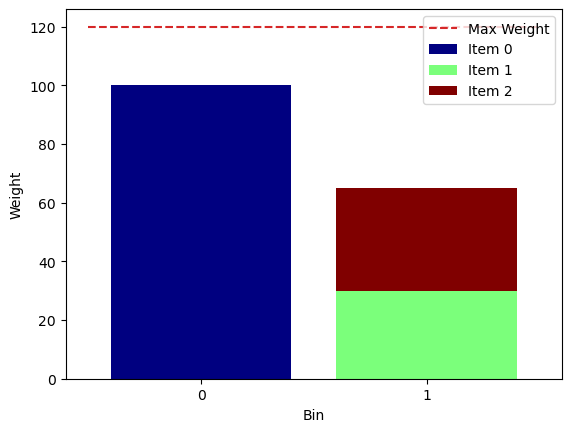

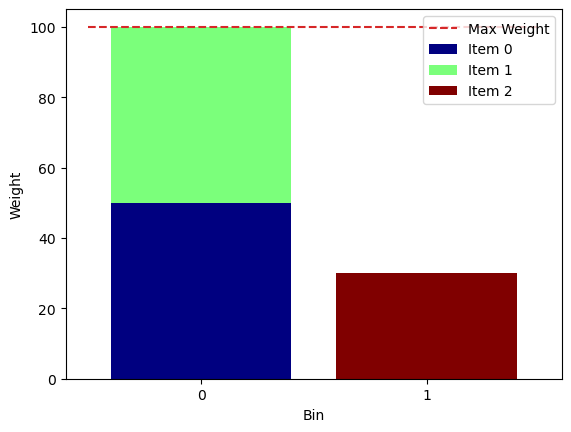

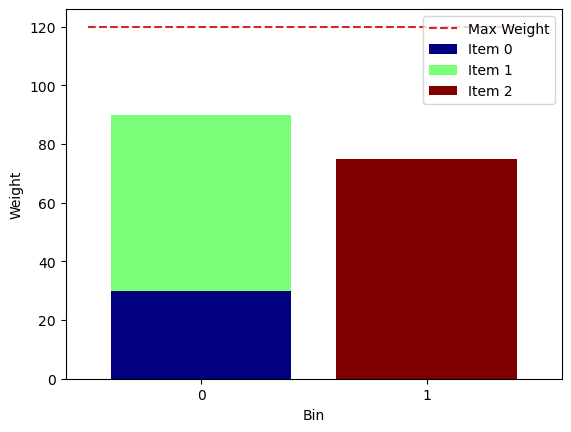

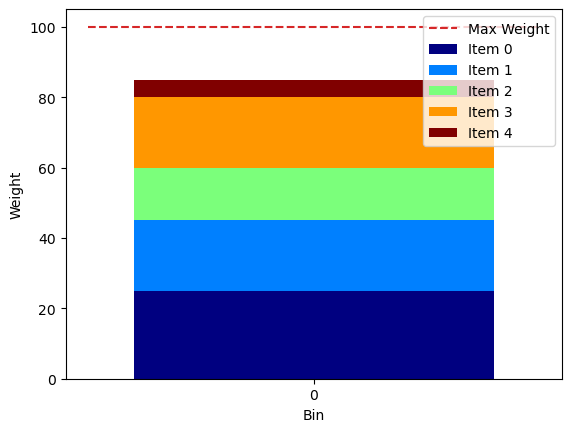

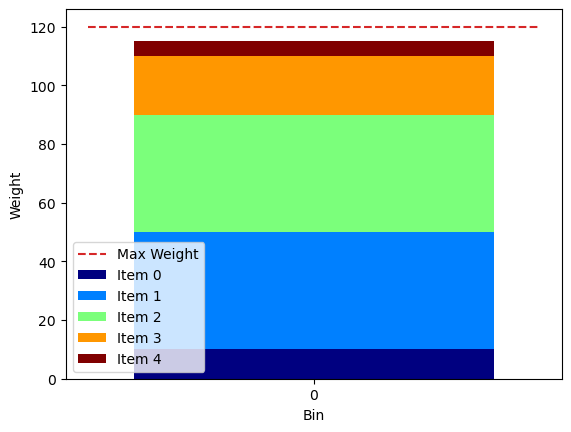

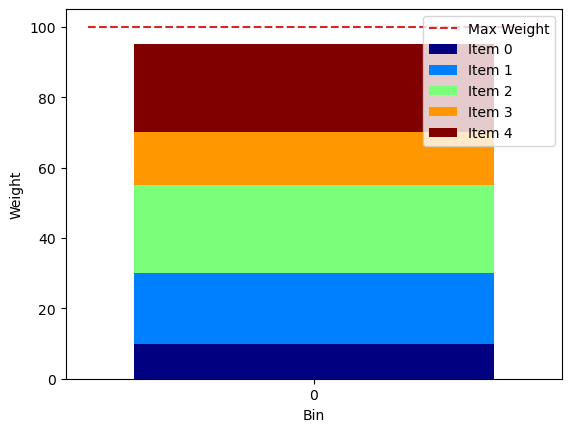

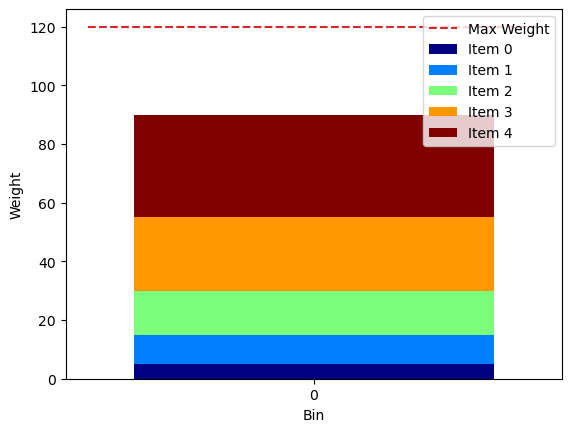

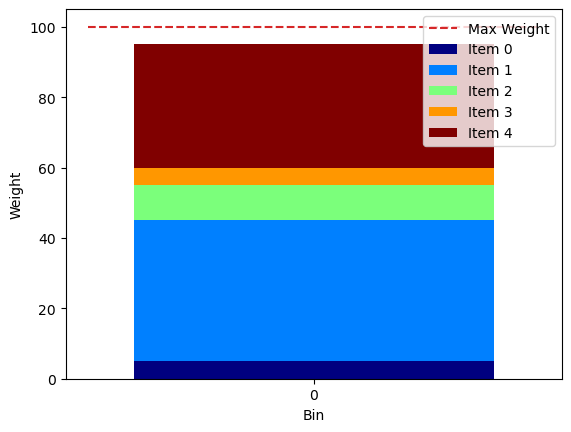

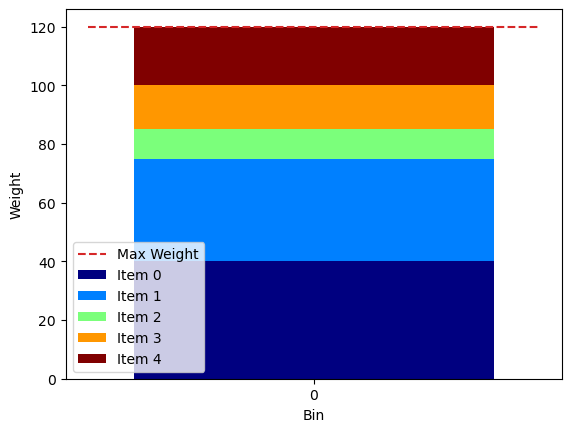

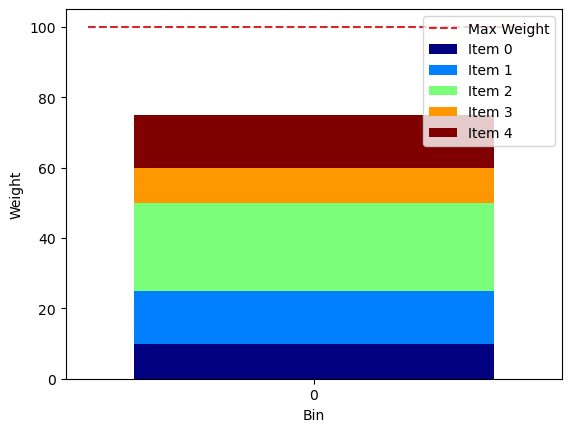

In [4]:
from docplex.mp.model import Model
from qiskit_optimization.algorithms import CplexOptimizer
from pprint import pp

instances = read_list("bpp_instances")


def test_classic(show_plot):
    results = []
    for bpp in instances:
        weights = bpp[0]  # item weights
        C = bpp[1]  # capacity of each bin
        B = bpp[2]  # num of bins
        items = bpp[3]  # num of items

        qp = quadratic_penalty(weights, C, B, items)
        cplex = CplexOptimizer()
        exact_result = cplex.solve(qp)

        results.append(interpret(exact_result, B, items))

        if show_plot:
            print("BPP instance:", bpp)
            print(f"Result:", exact_result)
            print(f"Number of variables: {len(exact_result.variables)}")
            print(f"Interpreted result: {interpret(exact_result, B, items)}")

            _ = plot(exact_result, B, items, weights, C)

    return results


test_classic(show_plot=True)

## QAOA solution


In [14]:
# from qiskit.algorithms.minimum_eigensolvers import QAOA

# Use this import instead because the one above is deprecated
from qiskit_algorithms import QAOA

from qiskit_algorithms.optimizers import COBYLA
from qiskit import Aer
from qiskit_algorithms.utils import algorithm_globals
from qiskit.primitives import BackendSampler

# TODO: Test on GPU

backend = Aer.get_backend("aer_simulator")
backend.set_options(device="GPU")
algorithm_globals.random_seed = 10598

optimizer = COBYLA()

qaoa = QAOA(
    sampler=BackendSampler(backend), optimizer=optimizer, initial_point=[0.0, 0.0]
)

# QUBO as an Ising Hamiltonian
operator, offset = qp.to_ising()

result_qaoa = qaoa.compute_minimum_eigenvalue(operator=operator)

print(result_qaoa)

RuntimeError: Simulation device "GPU" is not supported on this system

## Warm start QAOA


In [17]:
# from qiskit.algorithms.minimum_eigensolvers import QAOA

# Use this import instead because the one above is deprecated
from qiskit_algorithms import QAOA
from qiskit_optimization.algorithms import WarmStartQAOAOptimizer, CplexOptimizer

# TODO: Ising missing

algorithm_globals.random_seed = 10598
backend = Aer.get_backend("aer_simulator")
backend.set_options(device="GPU")
qaoa_mes = QAOA(
    sampler=BackendSampler(backend), optimizer=COBYLA(), initial_point=[1, 5]
)
qaoa = WarmStartQAOAOptimizer(
    pre_solver=CplexOptimizer(), relax_for_pre_solver=False, qaoa=qaoa_mes
)

print(qaoa.solve(qp))

RuntimeError: Simulation device "GPU" is not supported on this system

# Evaluation


Evaluate quantum solutions in comparison with classic solution using the following metrics:

- Running time;
- Mean square error between quantum optimum and classic optimum;
- Number of times each algorithm reaches the optimum;

Evaluation should be performed on the following backends:

- Noiseless simulator (Aer)
- Noisy simulator (choose a noise model)
- BONUS: test on AQT simulator (check https://github.com/qiskit-community/qiskit-aqt-provider)

QAOA should be evaluated using different configurations:

- QAOAAnsatz with $p=[1,5]$
- Optimizers: COBYLA, NelderMead, SLSQP
- Shots: {200, 400, 600, 800, 1000} (Please note that AQT backend is limited to 200 shots)
- Optimizers' iteration: {250, 500, 750, 1000}


In [7]:
import time
import datetime

start_classic = time.time()
results = test_classic(show_plot=False)
delta_classic = datetime.timedelta(seconds=time.time() - start_classic)
print(f"CPLEX took {str(delta_classic).split('.')[0]} (h:mm:s)")

CPLEX took 0:00:09 (h:mm:s)
